# Optimizing Bank Marketing Strategies by Classifying Potential Customers

#### By Parker Lackland and Andrew Whisner

In [ ]:
##Sources

##https://datascience.stackexchange.com/questions/71804/how-to-perform-one-hot-encoding-on-multiple-categorical-columns

In [1]:
##Importing Necessary Libraries
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Data Preprocessing

In [4]:
##Reading in bank data
bank = pd.read_csv('/Users/parkerlackland/Documents/UNT/DTSC 5502 - Principles and Techniques for Data Science/bank.csv')

##Taking first glance at data and showing summary statistics
bank.head()


age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [6]:
bank.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

In [8]:
##Checking for null values
nulls = bank.isnull().any(axis = 1)
null_rows = bank[nulls]

null_rows

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, deposit]
Index: []

In [10]:
##Replacing all missing values of numeric data with median (imputing with the mean might not be as resistent to outliers)
##Calculating the mean of numeric columns
numeric_data = bank.select_dtypes('number')

numeric_data


age  balance  day  duration  campaign  pdays  previous
0       59     2343    5      1042         1     -1         0
1       56       45    5      1467         1     -1         0
2       41     1270    5      1389         1     -1         0
3       55     2476    5       579         1     -1         0
4       54      184    5       673         2     -1         0
...    ...      ...  ...       ...       ...    ...       ...
11157   33        1   20       257         1     -1         0
11158   39      733   16        83         4     -1         0
11159   32       29   19       156         2     -1         0
11160   43        0    8         9         2    172         5
11161   34        0    9       628         1     -1         0

[11162 rows x 7 columns]

In [12]:
##Filling missing values with the calculated median
median = numeric_data.median(skipna = True)
numeric_data.fillna(median, inplace = True)

##Seeing how summary statistics have changed due to median imputation
##They have not changed because there are no null values in the bank data
bank.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

In [15]:
##One-Hot Encoding all categorical columns to deal with categorical variables in regression analysis
##One-Hot Encoding shows the presence of each of the categorical values in the column by splitting the column into the amount of categories and giving it a value of 0 (no presence) or 1 (presence)

encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)

cat_encoded = encoder.fit_transform(bank[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']])

cat_encoded = pd.DataFrame(cat_encoded, columns = encoder.get_feature_names_out(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']))

bank_new = pd.concat([numeric_data, cat_encoded], axis = 1)

##adding target variable back
bank_new['deposit'] = bank['deposit']

##Changine 'yes' and 'no' to '1' and '0' in deposit column
bank_new['deposit'] = bank_new['deposit'].replace({'yes': 1, 'no': 0})

 

bank_new




/var/folders/g5/qbg81fx912z8nf6_dz7r_22c0000gn/T/ipykernel_56919/802427862.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bank_new['deposit'] = bank_new['deposit'].replace({'yes': 1, 'no': 0})


age  balance  day  duration  campaign  pdays  previous  job_admin.  \
0       59     2343    5      1042         1     -1         0         1.0   
1       56       45    5      1467         1     -1         0         1.0   
2       41     1270    5      1389         1     -1         0         0.0   
3       55     2476    5       579         1     -1         0         0.0   
4       54      184    5       673         2     -1         0         1.0   
...    ...      ...  ...       ...       ...    ...       ...         ...   
11157   33        1   20       257         1     -1         0         0.0   
11158   39      733   16        83         4     -1         0         0.0   
11159   32       29   19       156         2     -1         0         0.0   
11160   43        0    8         9         2    172         5         0.0   
11161   34        0    9       628         1     -1         0         0.0   

       job_blue-collar  job_entrepreneur  ...  month_mar  month_may  \
0                  0.0               0.0  ...        0.0        1.0   
1                  0.0               0.0  ...        0.0        1.0   
2                  0.0               0.0  ...        0.0        1.0   
3                  0.0               0.0  ...        0.0        1.0   
4                  0.0               0.0  ...        0.0        1.0   
...                ...               ...  ...        ...        ...   
11157              1.0               0.0  ...        0.0        0.0   
11158              0.0               0.0  ...        0.0        0.0   
11159              0.0               0.0  ...        0.0        0.0   
11160              0.0               0.0  ...        0.0        1.0   
11161              0.0               0.0  ...        0.0        0.0   

       month_nov  month_oct  month_sep  poutcome_failure  poutcome_other  \
0            0.0        0.0        0.0               0.0             0.0   
1            0.0        0.0        0.0               0.0             0.0   
2            0.0        0.0        0.0               0.0             0.0   
3            0.0        0.0        0.0               0.0             0.0   
4            0.0        0.0        0.0               0.0             0.0   
...          ...        ...        ...               ...             ...   
11157        0.0        0.0        0.0               0.0             0.0   
11158        0.0        0.0        0.0               0.0             0.0   
11159        0.0        0.0        0.0               0.0             0.0   
11160        0.0        0.0        0.0               1.0             0.0   
11161        0.0        0.0        0.0               0.0             0.0   

       poutcome_success  poutcome_unknown  deposit  
0                   0.0               1.0        1  
1                   0.0               1.0        1  
2                   0.0               1.0        1  
3                   0.0               1.0        1  
4                   0.0               1.0        1  
...                 ...               ...      ...  
11157               0.0               1.0        0  
11158               0.0               1.0        0  
11159               0.0               1.0        0  
11160               0.0               0.0        0  
11161               0.0               1.0        0  

[11162 rows x 96 columns]

## Exploratory Data Analysis and Feature Selection

In [18]:
##Using correlation heatmap and values for feature selection
##Finding most important attributes to the target variable
cor = bank_new.corr()
plt.figure(figsize = (100, 100))
sns.heatmap(cor, annot = True)



<Axes: >

In [20]:
cor_target = abs(cor['deposit'])
cor_target

age                 0.034901
balance             0.081129
day                 0.056326
duration            0.451919
campaign            0.128081
                      ...   
poutcome_failure    0.020714
poutcome_other      0.044059
poutcome_success    0.286642
poutcome_unknown    0.230470
deposit             1.000000
Name: deposit, Length: 96, dtype: float64

In [22]:
mean = cor_target.mean()
mean

0.09690517885844142

In [24]:
##Dropping least important columns from both tables. 
##deposit will also be dropped since it is the target variable

unimportant = cor_target[cor_target < 0.15]
unimportant  = pd.DataFrame(unimportant)
unimportant = unimportant.transpose()
unimportant

age   balance       day  campaign  previous  job_admin.  \
deposit  0.034901  0.081129  0.056326  0.128081  0.139867     0.00061   

         job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
deposit          0.10084          0.034443       0.024155        0.036301   

         ...  month_feb  month_jan  month_jul  month_jun  month_mar  \
deposit  ...    0.05171   0.021803   0.047368   0.018982   0.135438   

         month_nov  month_oct  month_sep  poutcome_failure  poutcome_other  
deposit   0.028278   0.133783   0.126901          0.020714        0.044059  

[1 rows x 79 columns]

In [26]:
drop_cols = bank_new.columns.intersection(unimportant.columns)
bank_new = bank_new.drop(columns = drop_cols)

bank = bank_new
bank

duration  pdays  housing_no  housing_yes  contact_cellular  \
0          1042     -1         0.0          1.0               0.0   
1          1467     -1         1.0          0.0               0.0   
2          1389     -1         0.0          1.0               0.0   
3           579     -1         0.0          1.0               0.0   
4           673     -1         1.0          0.0               0.0   
...         ...    ...         ...          ...               ...   
11157       257     -1         0.0          1.0               1.0   
11158        83     -1         1.0          0.0               0.0   
11159       156     -1         1.0          0.0               1.0   
11160         9    172         1.0          0.0               1.0   
11161       628     -1         1.0          0.0               1.0   

       contact_unknown  month_may  poutcome_success  poutcome_unknown  \
0                  1.0        1.0               0.0               1.0   
1                  1.0        1.0               0.0               1.0   
2                  1.0        1.0               0.0               1.0   
3                  1.0        1.0               0.0               1.0   
4                  1.0        1.0               0.0               1.0   
...                ...        ...               ...               ...   
11157              0.0        0.0               0.0               1.0   
11158              1.0        0.0               0.0               1.0   
11159              0.0        0.0               0.0               1.0   
11160              0.0        1.0               0.0               0.0   
11161              0.0        0.0               0.0               1.0   

       housing_no  housing_yes  contact_cellular  contact_unknown  month_may  \
0             0.0          1.0               0.0              1.0        1.0   
1             1.0          0.0               0.0              1.0        1.0   
2             0.0          1.0               0.0              1.0        1.0   
3             0.0          1.0               0.0              1.0        1.0   
4             1.0          0.0               0.0              1.0        1.0   
...           ...          ...               ...              ...        ...   
11157         0.0          1.0               1.0              0.0        0.0   
11158         1.0          0.0               0.0              1.0        0.0   
11159         1.0          0.0               1.0              0.0        0.0   
11160         1.0          0.0               1.0              0.0        1.0   
11161         1.0          0.0               1.0              0.0        0.0   

       poutcome_success  poutcome_unknown  deposit  
0                   0.0               1.0        1  
1                   0.0               1.0        1  
2                   0.0               1.0        1  
3                   0.0               1.0        1  
4                   0.0               1.0        1  
...                 ...               ...      ...  
11157               0.0               1.0        0  
11158               0.0               1.0        0  
11159               0.0               1.0        0  
11160               0.0               0.0        0  
11161               0.0               1.0        0  

[11162 rows x 17 columns]

<Axes: >

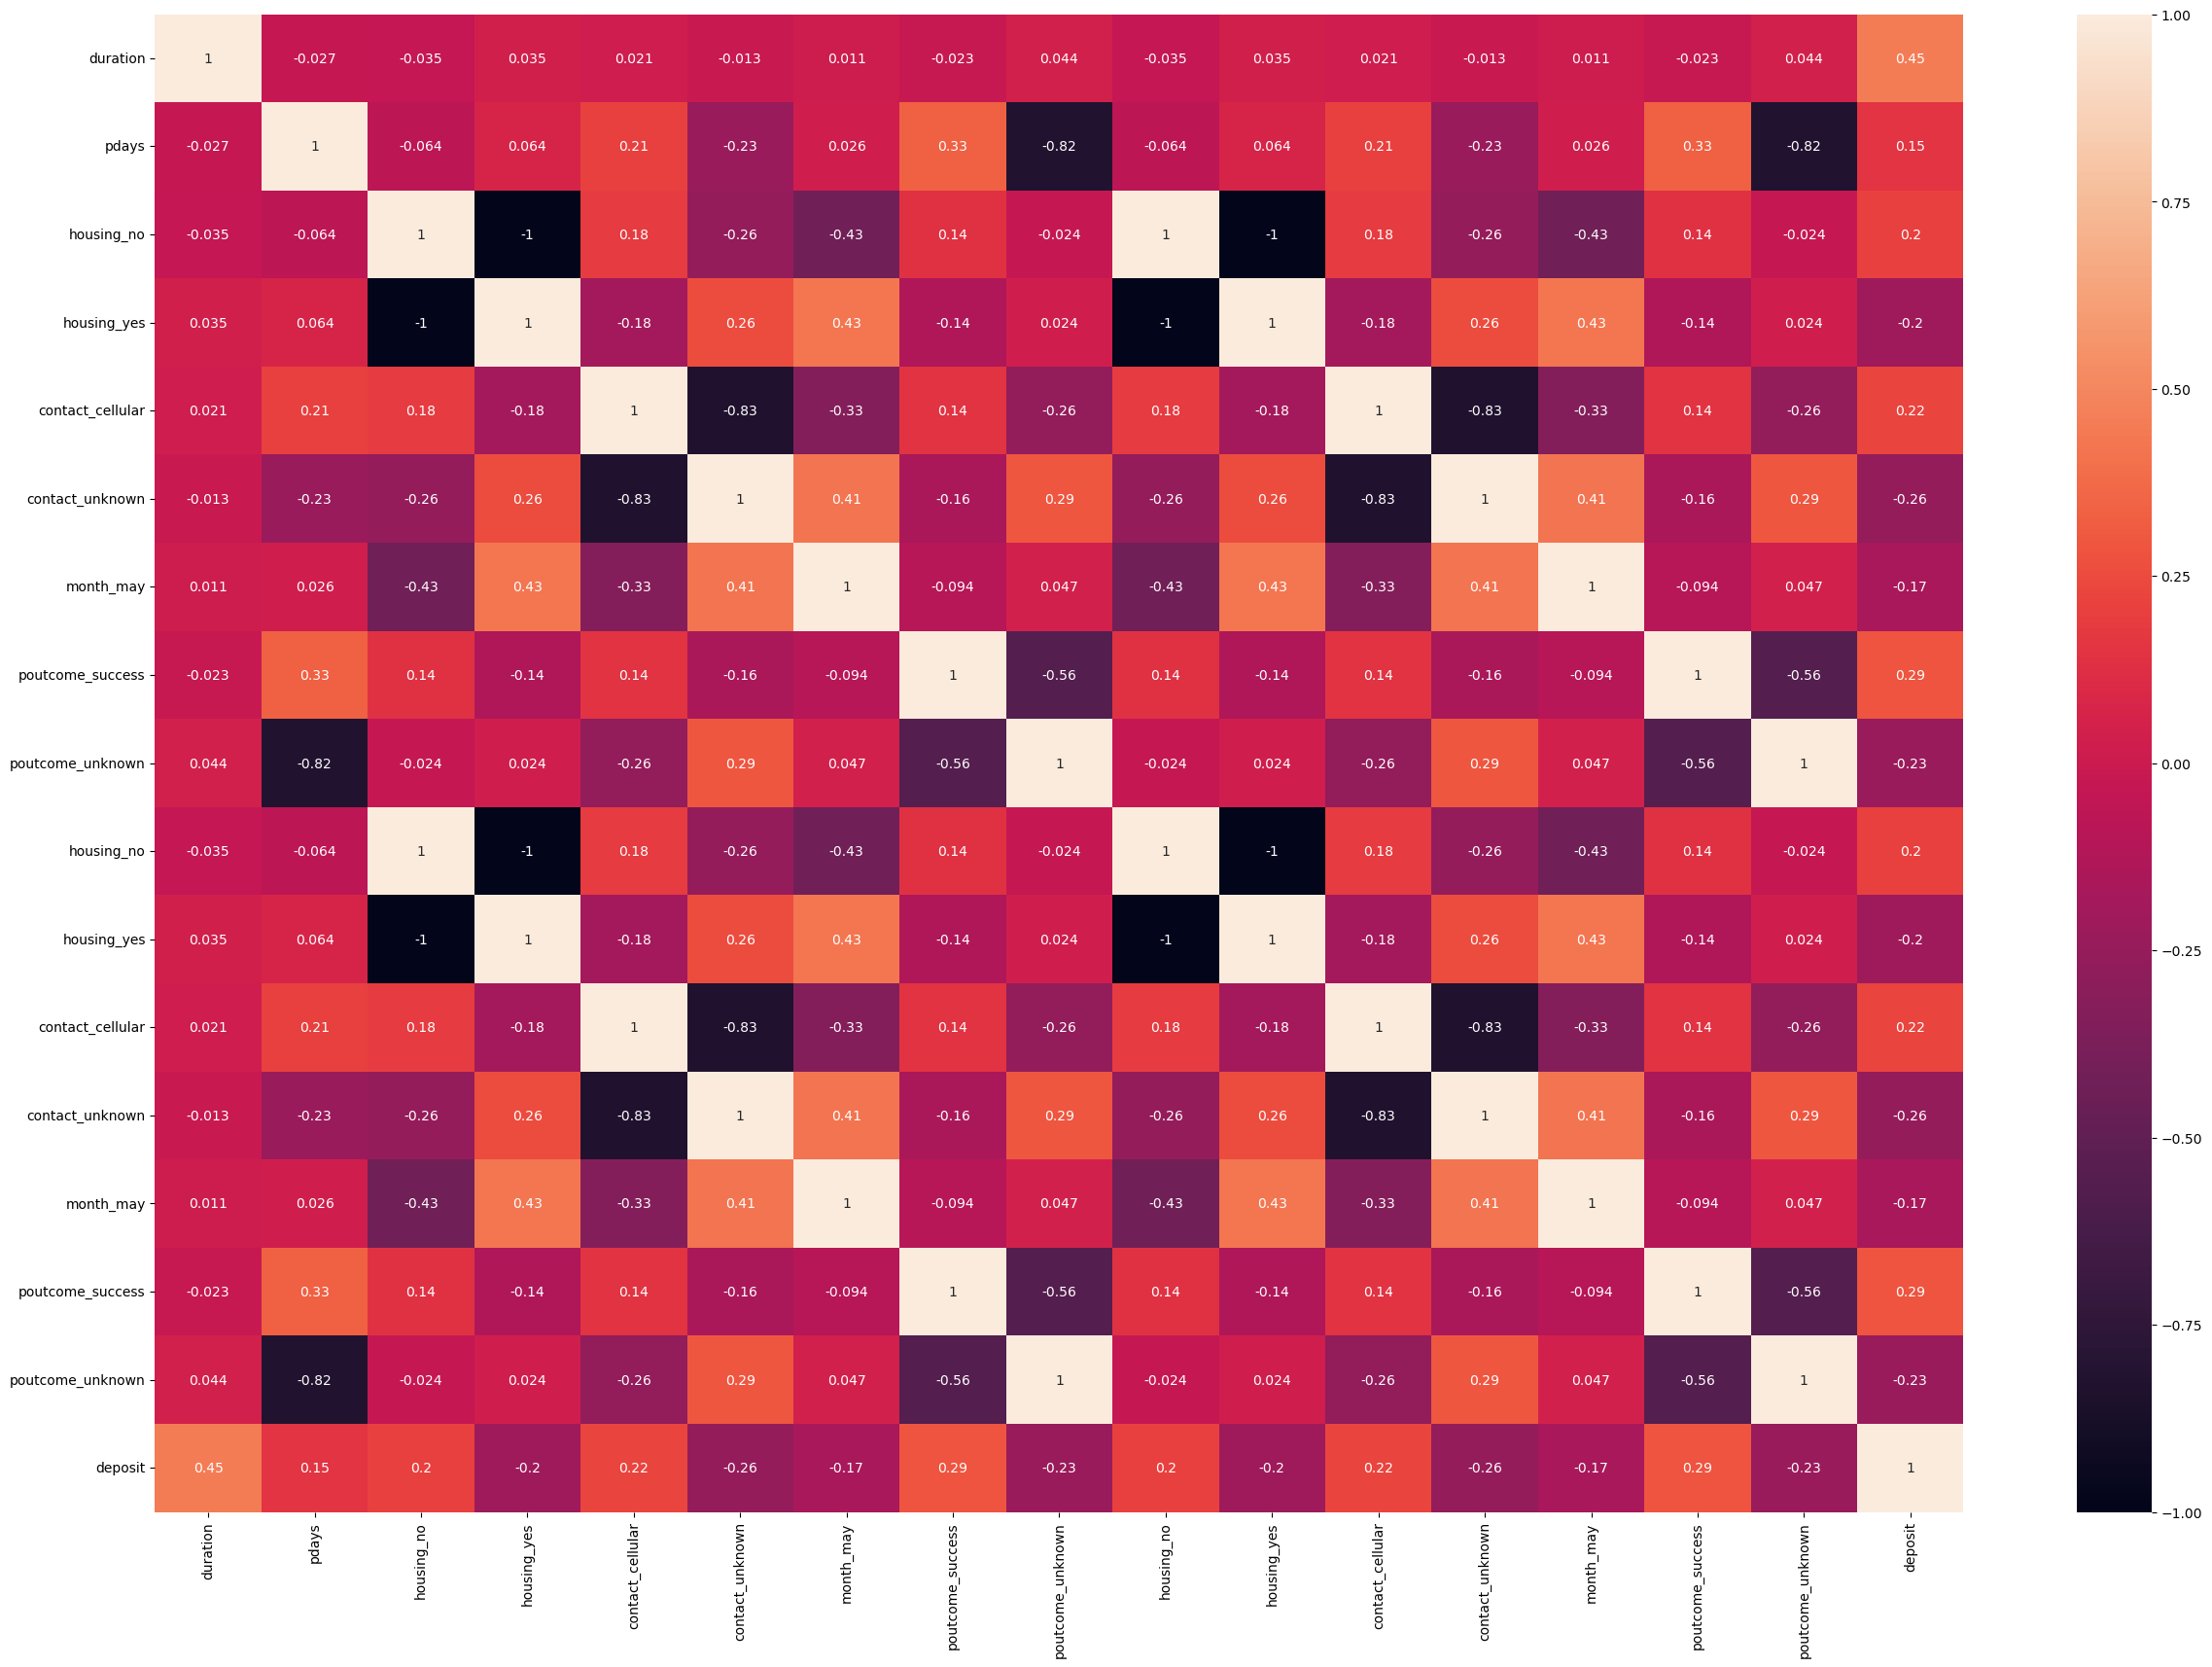

In [28]:
##Showing new correlation heatmap
cor_new = bank.corr()
plt.figure(figsize = (30, 20))
sns.heatmap(cor_new, annot = True)

In [30]:
##Showing most important variables
cor_target = abs(cor_new['deposit'])
cor_target

##Duration proves to be the most important variable to whether or not someone will deposit money or not. 

duration            0.451919
pdays               0.151593
housing_no          0.203888
housing_yes         0.203888
contact_cellular    0.223252
contact_unknown     0.256136
month_may           0.170507
poutcome_success    0.286642
poutcome_unknown    0.230470
housing_no          0.203888
housing_yes         0.203888
contact_cellular    0.223252
contact_unknown     0.256136
month_may           0.170507
poutcome_success    0.286642
poutcome_unknown    0.230470
deposit             1.000000
Name: deposit, dtype: float64

## Training Models on Competition Data

### Support Vector Classifier

In [34]:
##Splitting into Data and Target Variable
X = bank[bank.columns.difference(['deposit'], sort = False)]
y = bank['deposit']

##Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 123)


In [36]:
##standardizing data 
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [40]:
##Tuning hyperparameters
svc = SVC()

# Define the parameter grid
param_grid = {'kernel': ['linear', 'poly', 'rbf']}

  
  
grid_search = GridSearchCV(svc,param_grid, cv = 10, scoring = 'accuracy') 
        
grid_search.fit(X_train_scaled, y_train) 
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

Best Parameters: {'kernel': 'rbf'}
Best Accuracy Score: 0.7923614912197008


In [42]:
##Initializing svm model
svc = SVC(kernel = 'rbf')

##Fitting the model on training data
svc = svc.fit(X_train_scaled, y_train)

In [44]:
##Predicting on test data to tune hyperparameters
svcPredict = pd.DataFrame(svc.predict(X_test_scaled), columns = ['deposit'])

##Evaluating model using 10-fold cross validation technique
##Specifying 10 folds for cross validation and setting seed for reproducibility
n_folds = 10
seed = 123

kfold = KFold(n_splits = n_folds, random_state = seed, shuffle = True)

results = cross_val_score(svc, X, y, cv = kfold, scoring = 'accuracy')

print("Average accuracy of SVC Model With Cross Validation: ",  results.mean())


Average accuracy of SVC Model With Cross Validation:  0.7677854147213319


### KNN Classifier

In [47]:
##Initializing Knn model
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {'n_neighbors': [10, 25, 50, 75, 100]}

  
  
grid_search = GridSearchCV(knn,param_grid, cv = 10, scoring = 'accuracy') 
        
grid_search.fit(X_train_scaled, y_train) 
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

Best Parameters: {'n_neighbors': 25}
Best Accuracy Score: 0.7914647557736053


In [49]:
##Initializing knn model
knn = KNeighborsClassifier(n_neighbors = 25)

##Fitting the model on training data
knn = knn.fit(X_train_scaled, y_train)

In [51]:
##Predicting on validation data to tune hyperparameters
knnPredict = pd.DataFrame(knn.predict(X_train_scaled), columns = ['deposit'])

##Evaluating model using 10-fold cross validation technique
##Specifying 10 folds for cross validation and setting seed for reproducibility
n_folds = 10
seed = 123

kfold = KFold(n_splits = n_folds, random_state = seed, shuffle = True)

results = cross_val_score(knn, X, y, cv = kfold, scoring = 'accuracy')

print("Average accuracy of Knn Model With Cross Validation: ",  results.mean())


Average accuracy of Knn Model With Cross Validation:  0.7737851483909474


### Random Forest Classifier

In [58]:
##Initializing RF model
RF = RandomForestClassifier(random_state = 123)

##Tuning Hyperparameters
param_grid = { 
    'n_estimators': [150, 300, 500, 1000], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [9, 15, 25], 
} 

grid_search = GridSearchCV(RF,param_grid, cv = 10, scoring = 'accuracy') 
        
grid_search.fit(X_train_scaled, y_train) 
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 25, 'n_estimators': 1000}
Best Accuracy Score: 0.8049044888243889


In [60]:
##Implementing these parameters
RF = RandomForestClassifier(max_depth = 6, max_features = 'sqrt', max_leaf_nodes = 9, n_estimators = 1000, random_state = 123)

In [62]:
##Fitting the model on training data
RF = RF.fit(X_train_scaled, y_train)

In [64]:
##Predicting on test data to tune hyperparameters
RFpredict = pd.DataFrame(RF.predict(X_test_scaled), columns = ['deposit'])

##Evaluating model using 10-fold cross validation technique
##Specifying 10 folds for cross validation and setting seed for reproducibility
n_folds = 10
seed = 123

kfold = KFold(n_splits = n_folds, random_state = seed, shuffle = True)

results = cross_val_score(RF, X, y, cv = kfold, scoring = 'accuracy')

print("Average accuracy of Random Forest Model With Cross Validation: ",  results.mean())

Average accuracy of Random Forest Model With Cross Validation:  0.801379142159458


## Logistic Regression

In [ ]:
##Initializing LR model
LR = LogisticRegression(random_state = 123)

##Tuning Hyperparameters
param_grid = [
    {'penalty':['l2'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [2500, 5000]
}
]

grid_search = GridSearchCV(LR,param_grid, cv = 10, scoring = 'accuracy') 
        
grid_search.fit(X_train_scaled, y_train) 
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score", best_score)

In [67]:
##Implementing these parameters
LR = LogisticRegression(C = 0.03359818286283781, max_iter = 2500, penalty = 'l2', solver = 'liblinear')

In [69]:
##Fitting the model on training data
LR = LR.fit(X_train_scaled, y_train)

In [71]:
##Predicting on testing data to tune hyperparameters
LRpredict = pd.DataFrame(LR.predict(X_test_scaled), columns = ['deposit'])

##Evaluating model using 10-fold cross validation technique
##Specifying 10 folds for cross validation and setting seed for reproducibility
n_folds = 10
seed = 123

kfold = KFold(n_splits = n_folds, random_state = seed, shuffle = True)

results = cross_val_score(LR, X, y, cv = kfold, scoring = 'accuracy')

print("Average accuracy of Logistic Regression Model With Cross Validation: ",  results.mean())

Average accuracy of Logistic Regression Model With Cross Validation:  0.7901815538933973


## Predictions

In [74]:
##Random Forest (chosen model) Predictions
RFpredict = pd.DataFrame(RF.predict(X_test_scaled), columns = ['deposit'])

RFpredict

deposit
0           1
1           0
2           1
3           1
4           0
...       ...
2228        0
2229        1
2230        0
2231        1
2232        0

[2233 rows x 1 columns]

In [76]:
##Changing 1s to yes and 0s to no again
RFpredict['deposit'] = RFpredict['deposit'].replace({1 : 'yes', 0 : 'no'})
RFpredict

deposit
0        yes
1         no
2        yes
3        yes
4         no
...      ...
2228      no
2229     yes
2230      no
2231     yes
2232      no

[2233 rows x 1 columns]

In [88]:
count_yes = (RFpredict['deposit'] == 'yes').sum()
count_no = (RFpredict['deposit'] == 'no').sum()

print('Predicted deposits: ', count_yes)
print('Predicted non-deposits: ', count_no)

Predicted deposits:  1082
Predicted non-deposits:  1151


In [90]:
##Random Forest Classifier was chosen because it predicted on the test data with the highest accuracy (about 80%).